## Wobble with a variable telluric spectrum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wobble

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starname = 'hip54287'
data = wobble.Data(starname+'_e2ds.hdf5', filepath='../data/', orders=[40])
model = wobble.Model(data)
model.add_star(starname)
model.add_telluric('tellurics', rvs_fixed=True)
nll_history, rvs_history, template_history, chis_history = wobble.optimize_order(model, data, 0, 
                niter=50, output_history=True)

  0%|          | 0/50 [00:00<?, ?it/s]

--- ORDER 0 ---


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


In [88]:
synth = tf.zeros_like(data.ys[0])
for c in [model.components[0]]: # stellar contribution
    synth += c.shift_and_interp(0, data.xs[0], c.rvs_block[0])
resids = data.ys[0] - synth
# interpolate resids to telluric rest frame: unnecessary bc RV_t = 0
s,u,v = tf.svd(resids, compute_uv=True)

In [89]:
reconstruction = tf.matmul(u*tf.diag(s),tf.transpose(tf.conj(v)))

In [98]:
session = wobble.get_session()

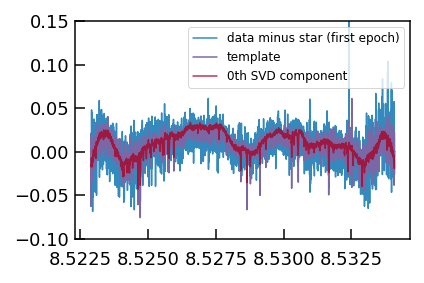

In [106]:
c = model.components[1]
plt.plot(session.run(data.xs[0][0]), session.run(resids[0]), label='data minus star (first epoch)')
plt.plot(session.run(c.template_xs[0]), session.run(c.template_ys[0]), label='template')
plt.plot(session.run(data.xs[0][0]), session.run(v[:,0]), alpha=0.8, label='0th SVD component')
#plt.plot(session.run(data.xs[0][0]), session.run(v[:,1]), alpha=0.6, label='1st SVD component')
plt.legend(loc='upper right', fontsize=12)
plt.ylim([-0.1,0.15])
plt.savefig('svd_template.png')